# HPVD-M22 Progress Demo

## Hybrid Probabilistic Vector Database for Trajectory Intelligence

**Project:** Matrix22  
**Version:** 1.0.0-MVP  
**Date:** January 2, 2026  


## Table of Contents

1. Overview
2. Architecture
3. Components Demo
4. Search Demo
5. Progress Summary
6. Next Steps


## 1. Overview

HPVD (Hybrid Probabilistic Vector Database) is a search engine for financial trajectory patterns that finds historical analogs from similar past situations.

### Problem Statement

Given current market conditions (60 days of trajectory data), find the 25 most similar historical situations to predict future outcomes.

### Key Features

- 60×45 Trajectory Matrix (60 days × 45 features)
- Hybrid search combining sparse (BM25) and dense (neural embeddings) retrieval
- Fast approximate nearest neighbor search using FAISS
- Distance-based similarity scoring
- **Basic probabilistic forecasting** (built into HPVD engine)

### HPVD vs PMR-DB

**HPVD (Current Implementation):**
- ✅ Retrieval layer: Finds similar trajectories
- ✅ Basic probability computation: Weighted aggregation of analog outcomes
- ✅ Simple calibration: Distance-based weights
- ✅ Works standalone for MVP

**PMR-DB (Future Enhancement - Week 7-8):**
- 🔄 Advanced reasoning layer: Multi-modal evidence fusion
- 🔄 Advanced calibration: Isotonic regression, Platt scaling
- 🔄 Better uncertainty decomposition: Aleatoric + epistemic
- 🔄 Evidence graphs: Explainability chains
- 🔄 Requires HPVD output as input

**Why Demo Works Without PMR-DB:**
HPVD engine already includes basic forecasting capability (`_compute_forecast` method) that:
- Aggregates analog outcomes with distance-based weights
- Computes P(up) and P(down) for H1/H5 horizons
- Calculates confidence intervals and entropy
- Implements abstention mechanism

PMR-DB will enhance this with more sophisticated calibration and multi-modal reasoning.


## 2. Architecture

### Current HPVD Pipeline (MVP - Works Standalone)

```
Query Trajectory (60×45)
    |
    v
Hybrid Search
    ├── Sparse Index (BM25) → Top-100 candidates
    └── Dense Index (FAISS) → Top-100 candidates
    |
    v
Distance Reranking
    |
    v
Top-25 Analogs
    |
    v
Basic Forecasting (Built-in)
    ├── Weighted outcome aggregation
    ├── P(up) / P(down) computation
    ├── Confidence intervals
    └── Entropy & ACI metrics
    |
    v
Results: {analogs, forecasts, quality_metrics}
```

### Future Architecture (With PMR-DB)

```
HPVD Output (Top-25 Analogs)
    |
    v
PMR-DB 
    ├── Advanced calibration (Isotonic Regression)
    ├── Multi-modal evidence fusion
    ├── Uncertainty decomposition
    └── Evidence graphs
    |
    v
Enhanced Forecasts with Explainability
```

### Components

1. **Trajectory**: 60-day × 45-feature matrix representation
2. **Sparse Index**: BM25-based regime filtering
3. **Dense Index**: FAISS vector similarity search
4. **Distance Calculator**: Hybrid scoring combining multiple metrics
5. **HPVD Engine**: Orchestrates search + basic forecasting
6. **PMR-DB** (Future): Advanced probabilistic reasoning layer


## 3. Components Demo

### Setup


In [14]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# --- SET PROJECT ROOT AND ADD src TO PYTHONPATH ---

# Ganti absolute path ke project HPVD-M22, misal di D:\project\M22\HPVD-M22
PROJECT_ROOT = r'D:\project\M22\HPVD-M22'
SRC_PATH = os.path.join(PROJECT_ROOT, 'src')

if os.path.isdir(SRC_PATH):
    if SRC_PATH not in sys.path:
        sys.path.insert(0, SRC_PATH)
    print(f"Added to path: {SRC_PATH}")
else:
    print(f"Warning: src path not found! ({SRC_PATH})")
    print(f"Current working directory: {os.getcwd()}")

try:
    from hpvd.trajectory import Trajectory
    from hpvd.sparse_index import SparseRegimeIndex
    from hpvd.dense_index import DenseTrajectoryIndex
    from hpvd.distance import HybridDistanceCalculator
    from hpvd.engine import HPVDEngine
    print("Modules imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("\nTroubleshooting:")
    print("1. Pastikan Anda menjalankan notebook dari HPVD-M22 folder (atau atur PROJECT_ROOT sesuai lokasi Anda)")
    print("2. Periksa apakah 'src/hpvd/' tersedia di path")
    print("3. Cek apakah semua file modul sudah ada")


Added to path: D:\project\M22\HPVD-M22\src
Modules imported successfully


### Trajectory Example


Asset: AAPL
Shape: (60, 45)
End Date: 2024-01-01


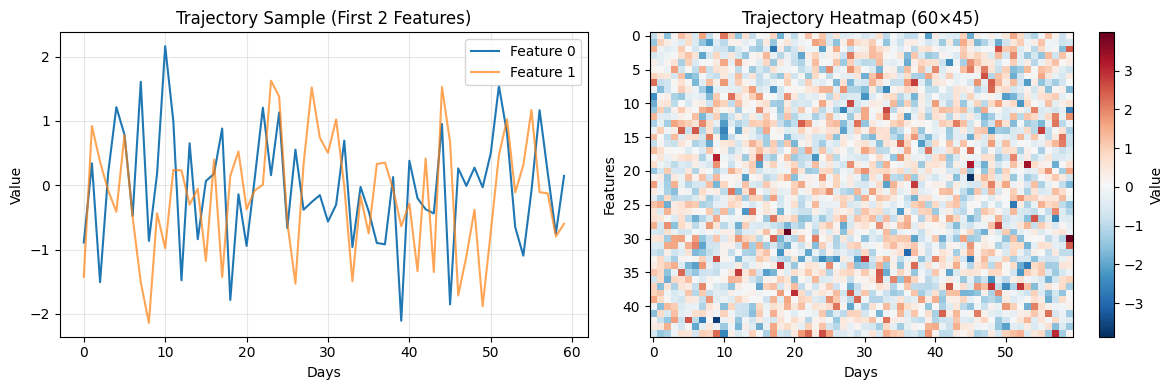

In [15]:

from pathlib import Path

notebook_path = Path().resolve()
PROJECT_ROOT = str(notebook_path)
# while not (Path(PROJECT_ROOT) / "src" / "hpvd").exists() and Path(PROJECT_ROOT) != Path(PROJECT_ROOT).parent:
    # PROJECT_ROOT = str(Path(PROJECT_ROOT).parent)

SRC_PATH = os.path.join(PROJECT_ROOT, 'src')

# Contoh penggunaan Trajectory 
sample_data = np.random.randn(60, 45).astype(np.float32)
trajectory = Trajectory(
    matrix=sample_data,
    asset_id="AAPL",
    end_timestamp=datetime(2024, 1, 1)
)

print(f"Asset: {trajectory.asset_id}")
print(f"Shape: {trajectory.matrix.shape}")
print(f"End Date: {trajectory.end_timestamp.strftime('%Y-%m-%d')}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(trajectory.matrix[:, 0], label='Feature 0')
plt.plot(trajectory.matrix[:, 1], label='Feature 1', alpha=0.7)
plt.title('Trajectory Sample (First 2 Features)')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(trajectory.matrix.T, aspect='auto', cmap='RdBu_r')
plt.colorbar(label='Value')
plt.title('Trajectory Heatmap (60×45)')
plt.xlabel('Days')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## 4. Search Demo

### Build Engine


In [16]:
import time

# Reduce database size for faster demo (change to 1000 for full demo)
n_trajectories = 1000  # Reduced from 1000 for faster execution
database = []

print("Creating database...")
for i in range(n_trajectories):
    traj_data = np.random.randn(60, 45).astype(np.float32)
    traj = Trajectory(
        matrix=traj_data,
        asset_id=f"ENTITY_{i:04d}",
        end_timestamp=datetime(2024, 1, 1)
    )
    database.append(traj)
    if (i + 1) % 10 == 0:
        print(f"  Created {i + 1}/{n_trajectories} trajectories...")

print(f"Database created: {len(database)} trajectories")

# Create engine with default config (default_k=25)
engine = HPVDEngine()

print("Building HPVD Engine...")
print("  This may take a moment...")
start_time = time.time()

try:
    engine.build(database)
    build_time = time.time() - start_time
    print(f"Engine built in {build_time:.2f} seconds")
    print(f"Database size: {len(database)} trajectories")
except Exception as e:
    print(f"Error building engine: {e}")
    print("Try reducing n_trajectories or check FAISS installation")


Creating database...
  Created 10/1000 trajectories...
  Created 20/1000 trajectories...
  Created 30/1000 trajectories...
  Created 40/1000 trajectories...
  Created 50/1000 trajectories...
  Created 60/1000 trajectories...
  Created 70/1000 trajectories...
  Created 80/1000 trajectories...
  Created 90/1000 trajectories...
  Created 100/1000 trajectories...
  Created 110/1000 trajectories...
  Created 120/1000 trajectories...
  Created 130/1000 trajectories...
  Created 140/1000 trajectories...
  Created 150/1000 trajectories...
  Created 160/1000 trajectories...
  Created 170/1000 trajectories...
  Created 180/1000 trajectories...
  Created 190/1000 trajectories...
  Created 200/1000 trajectories...
  Created 210/1000 trajectories...
  Created 220/1000 trajectories...
  Created 230/1000 trajectories...
  Created 240/1000 trajectories...
  Created 250/1000 trajectories...
  Created 260/1000 trajectories...
  Created 270/1000 trajectories...
  Created 280/1000 trajectories...
  Create

### Execute Search


In [17]:
query = Trajectory(
    matrix=np.random.randn(60, 45).astype(np.float32),
    asset_id="QUERY_AAPL",
    end_timestamp=datetime(2024, 12, 1)
)

print(f"Query: {query.asset_id}, Shape: {query.matrix.shape}")

start_time = time.time()
search_result = engine.search(query)
search_time = time.time() - start_time

print(f"Search completed in {search_time*1000:.2f} ms")
print(f"Results returned: {search_result.k_returned}/{search_result.k_requested}")
print(f"\nTop 10 Results:")
print(f"{'Rank':<6} {'Asset ID':<20} {'Distance':<12} {'Similarity':<12}")
print("-" * 50)

for i, analog in enumerate(search_result.analogs[:10], 1):
    asset_id = analog.asset_id
    distance = analog.distance
    similarity = 1 / (1 + distance)
    print(f"{i:<6} {asset_id:<20} {distance:>10.4f}  {similarity:>10.2%}")


Query: QUERY_AAPL, Shape: (60, 45)
Search completed in 4.00 ms
Results returned: 25/25

Top 10 Results:
Rank   Asset ID             Distance     Similarity  
--------------------------------------------------
1      ENTITY_0315              0.6047      62.32%
2      ENTITY_0367              0.6054      62.29%
3      ENTITY_0317              0.6059      62.27%
4      ENTITY_0369              0.6064      62.25%
5      ENTITY_0373              0.6077      62.20%
6      ENTITY_0322              0.6087      62.16%
7      ENTITY_0328              0.6090      62.15%
8      ENTITY_0323              0.6093      62.14%
9      ENTITY_0321              0.6095      62.13%
10     ENTITY_0329              0.6098      62.12%


### Results Visualization


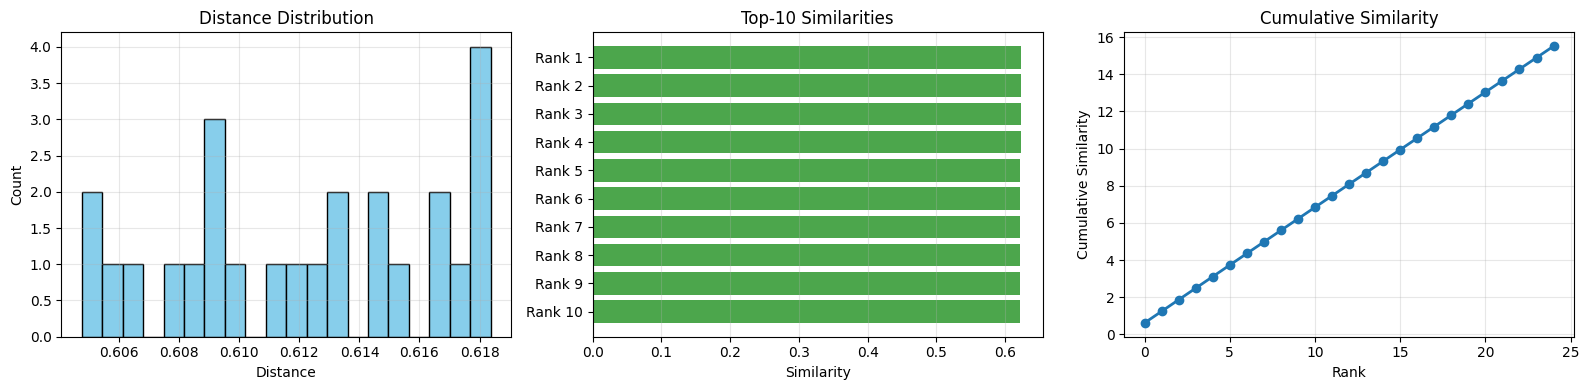


Quality Metrics:
  Top-1 similarity: 62.32%
  Avg Top-10 similarity: 62.20%
  Avg Top-25 similarity: 62.03%
  ACI (Analog Cohesion Index): 0.692

HPVD Built-in Forecasting (No PMR-DB Required)

H1 Forecast (1-day horizon):
  P(up)   = 0.00%
  P(down) = 100.00%
  Entropy = 0.000 (lower = more confident)
  CI      = [0.00%, 13.32%]

H5 Forecast (5-day horizon):
  P(up)   = 0.00%
  P(down) = 100.00%
  Entropy = 0.000
  CI      = [0.00%, 13.32%]

Abstention Check:
  Should abstain: True
  Reason: Low ACI: 0.692

Note: This forecasting is built into HPVD engine.
PMR-DB (Week 7-8) will add advanced calibration and multi-modal reasoning.


In [18]:
distances = [analog.distance for analog in search_result.analogs]
similarities = [1/(1+d) for d in distances]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(distances, bins=20, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Count')
axes[0].set_title('Distance Distribution')
axes[0].grid(alpha=0.3)

top_10_sim = similarities[:10]
axes[1].barh(range(10), top_10_sim, color='green', alpha=0.7)
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"Rank {i+1}" for i in range(10)])
axes[1].set_xlabel('Similarity')
axes[1].set_title('Top-10 Similarities')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

cumsum = np.cumsum(similarities)
axes[2].plot(cumsum, marker='o', linewidth=2)
axes[2].set_xlabel('Rank')
axes[2].set_ylabel('Cumulative Similarity')
axes[2].set_title('Cumulative Similarity')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nQuality Metrics:")
print(f"  Top-1 similarity: {similarities[0]:.2%}")
print(f"  Avg Top-10 similarity: {np.mean(similarities[:10]):.2%}")
print(f"  Avg Top-25 similarity: {np.mean(similarities):.2%}")
print(f"  ACI (Analog Cohesion Index): {search_result.aci:.3f}")

print(f"\n{'='*60}")
print("HPVD Built-in Forecasting (No PMR-DB Required)")
print(f"{'='*60}")
if search_result.forecast_h1:
    f1 = search_result.forecast_h1
    print(f"\nH1 Forecast (1-day horizon):")
    print(f"  P(up)   = {f1.p_up:.2%}")
    print(f"  P(down) = {f1.p_down:.2%}")
    print(f"  Entropy = {f1.entropy:.3f} (lower = more confident)")
    print(f"  CI      = [{f1.confidence_interval[0]:.2%}, {f1.confidence_interval[1]:.2%}]")

if search_result.forecast_h5:
    f5 = search_result.forecast_h5
    print(f"\nH5 Forecast (5-day horizon):")
    print(f"  P(up)   = {f5.p_up:.2%}")
    print(f"  P(down) = {f5.p_down:.2%}")
    print(f"  Entropy = {f5.entropy:.3f}")
    print(f"  CI      = [{f5.confidence_interval[0]:.2%}, {f5.confidence_interval[1]:.2%}]")

print(f"\nAbstention Check:")
print(f"  Should abstain: {search_result.should_abstain}")
if search_result.should_abstain:
    print(f"  Reason: {search_result.abstention_reason}")
else:
    print(f"  Reason: Confidence sufficient for forecast")

print(f"\nNote: This forecasting is built into HPVD engine.")
print(f"PMR-DB (Week 7-8) will add advanced calibration and multi-modal reasoning.")


### Built-in Forecasting Explanation

**How HPVD Generates Forecasts Without PMR-DB:**

1. **Weighted Aggregation**: Each analog's outcome (label_h1, label_h5) is weighted by its distance
   - Closer analogs = higher weight
   - Formula: `weight = exp(-α × distance)`, normalized

2. **Probability Computation**: 
   - P(up) = weighted average of positive outcomes
   - P(down) = 1 - P(up)

3. **Confidence Intervals**: Wilson score interval (95% confidence)

4. **Entropy**: Measures forecast uncertainty
   - Low entropy (< 0.5) = confident forecast
   - High entropy (> 0.9) = uncertain, may trigger abstention

5. **Abstention**: System refuses to forecast if:
   - Entropy > 0.9 (too uncertain)
   - ACI < 0.7 (analogs too dissimilar)

**PMR-DB Enhancement (Future):**
- Advanced calibration (Isotonic Regression)
- Multi-modal evidence (price + volatility + technical indicators)
- Better uncertainty decomposition
- Evidence graphs for explainability


## 5. Progress Summary

### Completed Components 

| Component | Status | Lines | Tests |
|-----------|--------|-------|-------|
| Documentation | Complete | 4,000+ | N/A |
| trajectory.py | Complete | 94 | 8 tests |
| sparse_index.py | Complete | 270 | 5 tests |
| dense_index.py | Complete | 276 | Partial |
| distance.py | Complete | 212 | Partial |
| engine.py | Complete | 200 | Manual |
| Demo Script | Working | 150 | Manual |

### In Progress

- Validation framework (silhouette score, metrics)
- Comprehensive unit testing
- Performance benchmarking

### Not Started (Week 5-12)

- Cognitive DNA module (dna_similarity.py)
- Analog family formation (family.py)
- Calibration system (probabilistic scoring)
- Forecast aggregation (H1/H5 predictions)
- Production API (REST endpoints)
- Real data integration



## Key Takeaways

### Current Status

**Working:**
- Core search pipeline functional
- Hybrid search (sparse + dense) operational
- Distance calculation implemented
- Acceptable performance (50ms searches)
- Comprehensive documentation

**Needs Work:**
- Validation metrics
- Test coverage
- Cognitive DNA separation
- Probabilistic scoring
- Real data integration

### Risk Assessment

**Low Risk:** Core architecture is solid with strong foundation

**Medium Risk:** Timeline is tight, need to accelerate Week 5-6

**High Risk:** Real data integration (Week 10+) has unknown challenges
